In [0]:
%%capture
!pip install transformers

In [0]:
import pandas as pd
import numpy as np

import transformers
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig

from tqdm.notebook import tqdm

import torch

import matplotlib.pyplot as plt

In [29]:
sentneces_df = pd.read_csv('drive/My Drive/!UBS/DW/data/scored_sentences.csv', index_col=0)
print(sentneces_df.shape)
sentneces_df.head()

(147062, 3)


,sha,sentence,score
0,f056da9c64fbf00a4645ae326e8a4339d015d155,Metagenomic classification methods are based o...,0.000000
1,f056da9c64fbf00a4645ae326e8a4339d015d155,A representative set of recent methods are des...,0.000000
2,f056da9c64fbf00a4645ae326e8a4339d015d155,genus or species) across the entire tree of life.,0.000000
3,f056da9c64fbf00a4645ae326e8a4339d015d155,They generally require reference databases tha...,0.000000
4,f056da9c64fbf00a4645ae326e8a4339d015d155,The gap SIANN is designed to fill is when the ...,0.051282


In [30]:
# Filter out links as they disturb classification
sentneces_df = sentneces_df[~sentneces_df['sentence'].str.contains('https://')]
sentneces_df.shape

(138169, 3)

In [31]:
# Filter out articles with less than 15 sentences
sentences_counts = sentneces_df['sha'].value_counts()
short_articles = sentences_counts[sentences_counts < 15]
sentneces_df = sentneces_df[~sentneces_df['sha'].isin(short_articles.index)]
sentneces_df.shape

(137302, 3)

In [32]:
# Filter out articles that do not have any relevant sentences
scores_sums = sentneces_df.groupby('sha')['score'].sum()
irrelevant_articles = scores_sums[scores_sums < 1]
sentneces_df = sentneces_df[~sentneces_df['sha'].isin(irrelevant_articles.index)]
sentneces_df.shape

(127326, 3)

In [33]:
# Reset indexes to be able to use them
sentneces_df = sentneces_df.reset_index(drop=True)
sentneces_df.head()

,sha,sentence,score
0,f056da9c64fbf00a4645ae326e8a4339d015d155,Metagenomic classification methods are based o...,0.000000
1,f056da9c64fbf00a4645ae326e8a4339d015d155,A representative set of recent methods are des...,0.000000
2,f056da9c64fbf00a4645ae326e8a4339d015d155,genus or species) across the entire tree of life.,0.000000
3,f056da9c64fbf00a4645ae326e8a4339d015d155,They generally require reference databases tha...,0.000000
4,f056da9c64fbf00a4645ae326e8a4339d015d155,The gap SIANN is designed to fill is when the ...,0.051282


### Mark 5 best sentences in doc

In [0]:
grouped_articles = sentneces_df.groupby('sha')
best_sentences = grouped_articles.apply(lambda x: x.sort_values("score", ascending=False)[:5])
inds = [i[1] for i in best_sentences.index]
sentneces_df['important'] = np.where(sentneces_df.index.isin(inds), 1, 0)

In [35]:
print(sentneces_df.shape)
sentneces_df.head()

(127326, 4)


,sha,sentence,score,important
0,f056da9c64fbf00a4645ae326e8a4339d015d155,Metagenomic classification methods are based o...,0.000000,0
1,f056da9c64fbf00a4645ae326e8a4339d015d155,A representative set of recent methods are des...,0.000000,0
2,f056da9c64fbf00a4645ae326e8a4339d015d155,genus or species) across the entire tree of life.,0.000000,0
3,f056da9c64fbf00a4645ae326e8a4339d015d155,They generally require reference databases tha...,0.000000,0
4,f056da9c64fbf00a4645ae326e8a4339d015d155,The gap SIANN is designed to fill is when the ...,0.051282,0


In [0]:
# For POC make stuff shorter 
# sentneces_df = sentneces_df.iloc[:25000]
# print(sentneces_df.shape)

### Create embeddings of sentences based on CLS BERT token

---



In [0]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
config = DistilBertConfig(output_hidden_states = True)
model = DistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
model.cuda();

In [38]:
X = sentneces_df['sentence']
tokenized = [tokenizer.encode(x, add_special_tokens=True) for x in X]
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
print(padded.shape)
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

(127326, 141)
(127326, 141)


In [39]:
# Split  
no_batches = 2000
batched_padded = np.array_split(padded, no_batches)
batched_attention_mask = np.array_split(attention_mask, no_batches)
# Create vector of features that are CLS tokens
features = []
for tokens, mask in tqdm(list(zip(batched_padded, batched_attention_mask))):
    # Create tensors and run through the model
    X_tensor = torch.tensor(tokens).cuda()  
    attention_mask_tensor = torch.tensor(mask).cuda()

    last_hidden_states = model(X_tensor, attention_mask=attention_mask_tensor)
    cls_tokens = last_hidden_states[0][:,0,:].cpu().detach().numpy()
    features.append(cls_tokens)

In [40]:
features_stacked = np.concatenate(features, axis=0)
features_stacked.shape

(127326, 768)

### Torch Sentence Selector Model

In [0]:
class DocumentEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(768, 768)
    def forward(self, doc_features):
        doc_mean = torch.mean(doc_features, axis=0)
        return torch.tanh(doc_mean)

In [0]:
class SentenceSelector(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(768*2, 768) # IN: CLS + doc rep
        self.l2 = torch.nn.Linear(768, 124)
        self.l3 = torch.nn.Linear(124, 1)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, doc_rep, sentences):
        # Append doc_rep to each sentence to create batch of inputs
        mult_doc_rep = doc_rep.reshape(1,-1).repeat(sentences.shape[0], 1)
        x = torch.cat([mult_doc_rep, sentences], axis=1)

        x = self.dropout(torch.relu(self.l1(x)))
        x = self.dropout(torch.relu(self.l2(x)))
        output = torch.sigmoid(self.l3(x))

        return output

In [43]:
# Test Models
sha, rows =  next(iter(sentneces_df.groupby('sha')))
test_input = features_stacked[rows.index]
test_input = torch.tensor(test_input)
print(test_input.shape)

model = DocumentEncoder()
doc_rep = model.forward(test_input)
print(doc_rep.shape)

# Fake input, example 3 sentences from document
sentneces = test_input[:3,:]
print(sentneces.shape)

model = SentenceSelector()
out = model.forward(doc_rep, sentneces)
print(out)

torch.Size([59, 768])
torch.Size([768])
torch.Size([3, 768])
tensor([[0.5247],
        [0.5084],
        [0.5172]], grad_fn=<SigmoidBackward>)


### Split articles for train, validation and test

In [44]:
articles_shas = sentneces_df['sha'].unique()
np.random.shuffle(articles_shas)
train_cut_off = round(0.2 * len(articles_shas))

train_articles = articles_shas[train_cut_off:]
valid_articles = articles_shas[:train_cut_off]

print(len(train_articles))
print(len(valid_articles))

1315
329


In [0]:
def get_doc_data(sentneces_df, features, sha):
    return features[sentneces_df['sha'] == sha]

def get_sent_train_data(sentneces_df, features, sha):
    corr = sentneces_df[(sentneces_df['sha'] == sha) & (sentneces_df['important'] == 1)].index
    wrong = sentneces_df[(sentneces_df['sha'] == sha) & (sentneces_df['important'] == 0)].index
    assert len(corr) < len(wrong)
    corr = np.random.choice(corr, len(wrong)) # Oversample
    features_out = features[np.concatenate((wrong.to_numpy(), corr))]
    labels_out = np.concatenate((np.ones(len(wrong)), np.zeros(len(corr))))

    return features_out, labels_out

def get_sent_test_data(sentneces_df, features, sha):
    corr = sentneces_df[(sentneces_df['sha'] == sha) & (sentneces_df['important'] == 1)].index
    wrong = sentneces_df[(sentneces_df['sha'] == sha) & (sentneces_df['important'] == 0)].index
    # Take only as many wrong as corr for balance test set 
    wrong = wrong[:len(corr)] 

    features_out = features[np.concatenate((wrong.to_numpy(), corr.to_numpy()))]
    labels_out = np.concatenate((np.ones(len(wrong)), np.zeros(len(corr))))

    return features_out, labels_out

### Train models

In [46]:
doc_model = DocumentEncoder()
sent_model = SentenceSelector()

criterion = torch.nn.BCELoss()

params = list(doc_model.parameters()) + list(sent_model.parameters())
optimizer = torch.optim.Adam(params, lr=5e-5)

doc_model.cuda()
sent_model.cuda()

SentenceSelector(
  (l1): Linear(in_features=1536, out_features=768, bias=True)
  (l2): Linear(in_features=768, out_features=124, bias=True)
  (l3): Linear(in_features=124, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [47]:
# Train loop 
n_epochs = 30

valid_loss_min = np.Inf
train_loss_hist = []
valid_loss_hist = []

# Iterate on epochs 
for epoch in range(1, n_epochs+1):
    # Train loop
    doc_model.train()
    sent_model.train()
    train_loss = 0.0
    for sha in train_articles:
        optimizer.zero_grad()
        # Get doc representation
        doc_features = get_doc_data(sentneces_df, features_stacked, sha)
        doc_features = torch.tensor(doc_features).cuda()
        doc_encoding = doc_model.forward(doc_features)

        # Get sentences 
        sent_features, sent_labels = get_sent_train_data(sentneces_df, features_stacked, sha)
        sent_features = torch.tensor(sent_features).cuda()
        sent_labels = torch.DoubleTensor(sent_labels).reshape(-1,1).cuda()

        out = sent_model.forward(doc_encoding, sent_features)

        loss = criterion(out.double(), sent_labels)
        train_loss += loss

        loss.backward()
        optimizer.step()

    # Validation loop
    doc_model.eval()
    sent_model.eval()
    valid_loss = 0.0
    all_matches = []
    with torch.no_grad():
        for sha in valid_articles:
            # Get doc representation
            doc_features = get_doc_data(sentneces_df, features_stacked, sha)
            doc_features = torch.tensor(doc_features).cuda()
            doc_encoding = doc_model.forward(doc_features)

            # Get sentences 
            sent_features, sent_labels = get_sent_test_data(sentneces_df, features_stacked, sha)
            sent_features = torch.tensor(sent_features).cuda()
            sent_labels = torch.DoubleTensor(sent_labels).reshape(-1,1).cuda()

            out = sent_model.forward(doc_encoding, sent_features)

            loss = criterion(out.double(), sent_labels)
            valid_loss += loss

            # Accuracy control
            pred = out.round()
            matches = (pred == sent_labels).reshape(-1).cpu().tolist()
            all_matches.extend(matches)

    epoch_train_loss = (train_loss / len(train_articles)).cpu().item()
    epoch_valid_loss = (valid_loss / len(valid_articles)).cpu().item()
    acc = (sum(all_matches) / len(all_matches)) * 100
    print('Epoch {}, Train loss: {:.3f}, Valid loss: {:.3f}, Valid acc: {:.3f}'.format(epoch, epoch_train_loss, epoch_valid_loss, acc))
    train_loss_hist.append(epoch_train_loss)
    valid_loss_hist.append(epoch_valid_loss)
    if epoch_valid_loss < valid_loss_min:
        valid_loss_min = epoch_valid_loss
        torch.save(doc_model.state_dict(), 'doc_model.pt')
        torch.save(sent_model.state_dict(), 'sent_model.pt')

Epoch 1, Train loss: 0.690, Valid loss: 0.681, Valid acc: 57.447
Epoch 2, Train loss: 0.687, Valid loss: 0.678, Valid acc: 57.386
Epoch 3, Train loss: 0.686, Valid loss: 0.676, Valid acc: 57.842
Epoch 4, Train loss: 0.685, Valid loss: 0.676, Valid acc: 57.781
Epoch 5, Train loss: 0.684, Valid loss: 0.673, Valid acc: 58.632
Epoch 6, Train loss: 0.682, Valid loss: 0.672, Valid acc: 58.450
Epoch 7, Train loss: 0.681, Valid loss: 0.673, Valid acc: 58.328
Epoch 8, Train loss: 0.680, Valid loss: 0.671, Valid acc: 59.149
Epoch 9, Train loss: 0.679, Valid loss: 0.669, Valid acc: 59.635
Epoch 10, Train loss: 0.677, Valid loss: 0.669, Valid acc: 59.848
Epoch 11, Train loss: 0.676, Valid loss: 0.666, Valid acc: 61.125
Epoch 12, Train loss: 0.674, Valid loss: 0.667, Valid acc: 60.821
Epoch 13, Train loss: 0.673, Valid loss: 0.668, Valid acc: 60.669
Epoch 14, Train loss: 0.671, Valid loss: 0.668, Valid acc: 61.216
Epoch 15, Train loss: 0.669, Valid loss: 0.667, Valid acc: 61.368
Epoch 16, Train los

<Figure size 432x288 with 0 Axes>

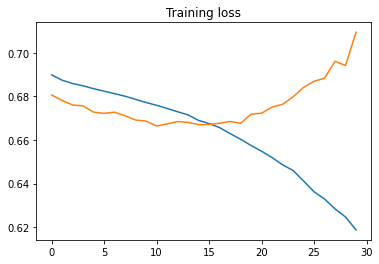

<Figure size 432x288 with 0 Axes>

In [48]:
# Plot loss
epochs = range(n_epochs)
 
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.title('Training loss')
 
plt.figure()

### Check Accuracy On Test Set

In [0]:
# # Set models to evaluation 
# doc_model.load_state_dict(torch.load('doc_model.pt'))
# sent_model.load_state_dict(torch.load('sent_model.pt'))

# doc_model.eval()
# sent_model.eval();

In [0]:
# # Run models on test set
# all_matches = []
# for sha in test_articles:
#     # Get doc representation
#     doc_features = get_doc_data(sentneces_df, features_stacked, sha)
#     doc_features = torch.tensor(doc_features).cuda()
#     doc_encoding = doc_model.forward(doc_features)

#     # Get sentences 
#     sent_features, sent_labels = get_sent_test_data(sentneces_df, features_stacked, sha)
#     sent_features = torch.tensor(sent_features).cuda()
#     sent_labels = torch.DoubleTensor(sent_labels).reshape(-1,1).cuda()

#     out = sent_model.forward(doc_encoding, sent_features)
#     pred = out.round()
#     matches = (pred == sent_labels).reshape(-1).cpu().tolist()
#     all_matches.extend(matches)

# acc = sum(all_matches) / len(all_matches) 
# print('Acc: {:.2f}%'.format(acc*100))